,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
497,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


Industrials               73
Information Technology    66
Health Care               65
Consumer Discretionary    53
Consumer Staples          37
Real Estate               30
Materials                 29
Communication Services    24
Energy                    23
Name: GICS Sector, dtype: int64


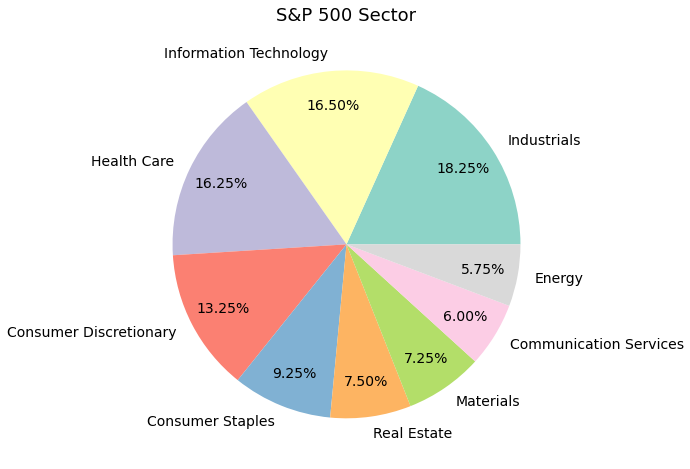

In [10]:
import pandas as pd

def read_wiki(): #根據危機百科的S&P 500 list
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#cite_note-2" #2023-4-25
    df = pd.read_html(url)[0]
    df = df.loc[(df['GICS Sector']!='Financials')&(df['GICS Sector']!='Utilities')]
    df.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv", index=False)
    return df

wiki = read_wiki()
#將symbol to txt
wiki['Symbol'].to_csv(r'D:/政大修課/111金融機構財務與風險管理/projectA/data/symbol.txt', header=None, index=None, sep=' ', mode='w')
display(wiki)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 8))

c = wiki['GICS Sector'].value_counts()
print(c)

ax.pie(c, labels=c.index, 
       autopct='%1.2f%%', 
       textprops={'fontsize':14}, 
       colors=sns.color_palette("Set3"),
      pctdistance=0.8)

ax.set_title('S&P 500 Sector', fontsize=18)

plt.savefig("D:/政大修課/111金融機構財務與風險管理/projectA/data/fig/sector.png" ,bbox_inches='tight')
plt.show() 

# rating 評級改變的債券 (2010Q4-2009Q4=20101231-20091231)

In [1]:
import numpy as np
import pandas as pd

df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")

df_rating = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/rating.csv")
df_rating.rename(columns={'tic':'Symbol'}, inplace=True)
df_rating = pd.merge(df_rating, df_wiki, on=['Symbol'], how='left')
#get gvkey (no Financials and Utilities)
df_rating['gvkey'].to_csv(r'D:/政大修課/111金融機構財務與風險管理/projectA/data/gvkey.txt', header=None, index=None, sep=' ', mode='w')

#時間格式
df_rating['datadate'] = pd.to_datetime(df_rating['datadate'])
df_rating['year'] = df_rating['datadate'].dt.year
df_rating['month'] = df_rating['datadate'].dt.month

#僅取2007-10-31 to 2010-3-31，評級有改變的債券
condiction1 = (df_rating['month'] == 12) & (df_rating['year'] == 2009)
condiction2 = (df_rating['month'] == 12) & (df_rating['year'] == 2010)
df_rating = df_rating[condiction1|condiction2]
# df_rating = df_rating[df_rating['month'] == 12]


#僅用長期債券
df_rating = df_rating[df_rating['splticrm'].notna()]

#對應債券評級
scale = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 'BB+', 'BB', 'BB-',
         'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'D', 'SD']
score = np.arange(len(scale)-1, -1, -1)
df_rating['splticrm_score'] = df_rating['splticrm'].replace(scale, score)

#升降及計算
df_rating['diff'] = df_rating.groupby(['gvkey', 'Symbol'])['splticrm_score'].diff()
df_rating = df_rating.dropna(subset=['diff'])
df_rating['dir_diff'] = np.where(df_rating['diff'] >0 , 'up', np.where(df_rating['diff'] < 0, 'down', 'flat'))
df_rating = df_rating[['gvkey', 'splticrm', 'datadate', 'cik', 'Symbol', 'GICS Sector', 'year', 'month', 'diff', 'dir_diff']]
df_rating.dropna(inplace=True)
df_rating.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/rating.csv")
display(df_rating)

#依照產業將評級改變的公司數量
dir_diff = pd.DataFrame(df_rating.groupby(['GICS Sector'])['dir_diff'].value_counts())
dir_diff.rename(columns={'dir_diff':'freq'}, inplace=True)
dir_diff.reset_index(inplace=True)
dir_diff = dir_diff.pivot(index='GICS Sector', columns='dir_diff', values='freq')
dir_diff.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/dir_diff.csv")
display(dir_diff)

,gvkey,splticrm,datadate,cik,Symbol,GICS Sector,year,month,diff,dir_diff
47,1045,B-,2010-12-31,6201,AAL,Industrials,2010,12,0.0,flat
143,1078,AA,2010-12-31,1800,ABT,Health Care,2010,12,0.0,flat
191,1161,B+,2010-12-31,2488,AMD,Information Technology,2010,12,2.0,up
239,1209,A,2010-12-31,2969,APD,Materials,2010,12,0.0,flat
287,1230,B+,2010-12-31,766421,ALK,Industrials,2010,12,1.0,up
...,...,...,...,...,...,...,...,...,...,...
20559,165123,A-,2010-12-31,1336920,LDOS,Industrials,2010,12,0.0,flat
20607,165746,B+,2010-12-31,1335258,LYV,Communication Services,2010,12,1.0,up
20763,176928,BBB,2010-12-31,1383312,BR,Industrials,2010,12,1.0,up
20808,177267,BBB,2010-12-31,1385157,TEL,Information Technology,2010,12,1.0,up


dir_diff,down,flat,up
GICS Sector,,,
Communication Services,3.0,7.0,3.0
Consumer Discretionary,3.0,24.0,10.0
Consumer Staples,3.0,25.0,4.0
Energy,NaN,15.0,1.0
Health Care,2.0,31.0,6.0
Industrials,1.0,44.0,6.0
Information Technology,NaN,17.0,7.0
Materials,1.0,21.0,2.0
Real Estate,NaN,23.0,1.0


# Bond Yield

In [154]:
# df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
# df_wiki = df_wiki[['Symbol', 'GICS Sector']]

#讀取債券資訊
df_bond = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/bond.csv")


#移除沒有殖利率與價格的資料
df_bond.dropna(subset=['yld_pt', 'rptd_pr'], inplace=True)

# #時間格式
df_bond['trd_exctn_datetime'] = pd.to_datetime(df_bond['trd_exctn_dt'] + ' ' + df_bond['trd_exctn_tm'])
df_bond['year'] = df_bond['trd_exctn_datetime'].dt.year
df_bond['month'] = df_bond['trd_exctn_datetime'].dt.month

# #僅用12月資料
df_bond = df_bond.loc[(df_bond['month']==12)&(df_bond['year']>=2003)]

#選擇當日最後一筆成交
dfs_bond  =  df_bond.groupby([df_bond['bond_sym_id'], df_bond['year'], df_bond['month']], as_index=False)['trd_exctn_datetime'].max()
df_bond = pd.merge(dfs_bond, df_bond, on=['bond_sym_id', 'trd_exctn_datetime', 'year', 'month'], how='left')
df_bond.rename(columns={'COMPANY_SYMBOL':'Symbol'}, inplace=True)
df_bond.drop_duplicates(['bond_sym_id', 'trd_exctn_datetime', 'Symbol'], inplace=True)

df_bond.to_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/bond.csv', index=False)
df_bond

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (2,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,bond_sym_id,year,month,trd_exctn_datetime,Symbol,bsym,trd_exctn_dt,trd_exctn_tm,ascii_rptd_vol_tx,rptd_pr,yld_pt,sttl_dt
0,A.GB,2004,12,2004-12-31 15:36:39,A,NaN,2004-12-31,15:36:39,23000,100.500,2.962000,NaN
2,A.GC,2007,12,2007-12-28 10:31:18,A,NaN,2007-12-28,10:31:18,135000,99.586,6.556052,NaN
3,A.GC,2008,12,2008-12-30 12:56:01,A,NaN,2008-12-30,12:56:01,75000,79.212,10.112505,NaN
4,A.GC,2009,12,2009-12-31 10:55:52,A,NaN,2009-12-31,10:55:52,2000000,106.708,5.433990,NaN
5,A.GC,2010,12,2010-12-31 09:38:16,A,NaN,2010-12-31,9:38:16,35000,109.965,4.770075,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
26598,YUM.GI,2009,12,2009-12-30 15:14:36,YUM,NaN,2009-12-30,15:14:36,1700000,101.471,3.958072,NaN
26599,YUM.GI,2010,12,2010-12-28 12:42:57,YUM,NaN,2010-12-28,12:42:57,25000,105.246,3.044055,NaN
26601,YUM.GJ,2009,12,2009-12-31 12:29:26,YUM,NaN,2009-12-31,12:29:26,25000,101.744,5.068618,NaN
26602,YUM.GJ,2010,12,2010-12-30 14:21:46,YUM,NaN,2010-12-30,14:21:46,5000,106.000,4.459178,NaN


In [155]:
df_bond.columns

Index(['bond_sym_id', 'year', 'month', 'trd_exctn_datetime', 'Symbol', 'bsym',
       'trd_exctn_dt', 'trd_exctn_tm', 'ascii_rptd_vol_tx', 'rptd_pr',
       'yld_pt', 'sttl_dt'],
      dtype='object')

# Merge Bond and Rating

In [23]:
import numpy as np
import pandas as pd
#債券殖利率
df_bond = pd.read_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/bond.csv')

#wiki sector
df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
df_wiki = df_wiki[['Symbol', 'GICS Sector']]

#評級，為了取得gvkey
df_rating = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/rating.csv")
df_rating = df_rating[['gvkey', 'splticrm', 'Symbol', 'dir_diff']]

#合併
dfs = pd.merge(df_bond, df_wiki, on=['Symbol'], how='left')
dfs = pd.merge(dfs, df_rating, on=['Symbol'], how='left')
display(dfs)

# gvkey = pd.DataFrame(np.unique(dfs['gvkey'].dropna().astype(int)))
# gvkey.to_csv(r'D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/gvkey.txt', header=None, index=None, sep=' ', mode='w')

print('OKOK')

,bond_sym_id,year,month,trd_exctn_datetime,Symbol,cusip_id,trd_exctn_dt,trd_exctn_tm,rptd_pr,yld_pt,GICS Sector,gvkey,splticrm,dir_diff
0,A.GB,2004,12,2004-12-31 15:36:39,A,00846UAB7,2004-12-31,15:36:39,100.500,2.962000,Health Care,126554.0,BBB-,flat
1,A.GC,2007,12,2007-12-28 10:31:18,A,00846UAC5,2007-12-28,10:31:18,99.586,6.556052,Health Care,126554.0,BBB-,flat
2,A.GC,2008,12,2008-12-30 12:56:01,A,00846UAC5,2008-12-30,12:56:01,79.212,10.112505,Health Care,126554.0,BBB-,flat
3,A.GC,2009,12,2009-12-31 10:55:52,A,00846UAC5,2009-12-31,10:55:52,106.708,5.433990,Health Care,126554.0,BBB-,flat
4,A.GC,2010,12,2010-12-31 09:38:16,A,00846UAC5,2010-12-31,9:38:16,109.965,4.770075,Health Care,126554.0,BBB-,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20440,YUM.GI,2009,12,2009-12-30 15:14:36,YUM,988498AE1,2009-12-30,15:14:36,101.471,3.958072,Consumer Discretionary,65417.0,BBB-,flat
20441,YUM.GI,2010,12,2010-12-28 12:42:57,YUM,988498AE1,2010-12-28,12:42:57,105.246,3.044055,Consumer Discretionary,65417.0,BBB-,flat
20442,YUM.GJ,2009,12,2009-12-31 12:29:26,YUM,988498AF8,2009-12-31,12:29:26,101.744,5.068618,Consumer Discretionary,65417.0,BBB-,flat
20443,YUM.GJ,2010,12,2010-12-30 14:21:46,YUM,988498AF8,2010-12-30,14:21:46,106.000,4.459178,Consumer Discretionary,65417.0,BBB-,flat


OKOK


In [24]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20445 entries, 0 to 20444
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bond_sym_id         20445 non-null  object 
 1   year                20445 non-null  int64  
 2   month               20445 non-null  int64  
 3   trd_exctn_datetime  20445 non-null  object 
 4   Symbol              20445 non-null  object 
 5   cusip_id            20445 non-null  object 
 6   trd_exctn_dt        20445 non-null  object 
 7   trd_exctn_tm        20445 non-null  object 
 8   rptd_pr             20445 non-null  float64
 9   yld_pt              20445 non-null  float64
 10  GICS Sector         20445 non-null  object 
 11  gvkey               19226 non-null  float64
 12  splticrm            19226 non-null  object 
 13  dir_diff            19226 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.3+ MB


In [25]:
dfs[dfs['gvkey'].isna()]

,bond_sym_id,year,month,trd_exctn_datetime,Symbol,cusip_id,trd_exctn_dt,trd_exctn_tm,rptd_pr,yld_pt,GICS Sector,gvkey,splticrm,dir_diff
114,ADBE.GA,2010,12,2010-12-31 12:01:46,ADBE,00724FAA9,2010-12-31,12:01:46,101.990,2.729977,Information Technology,NaN,NaN,NaN
115,ADBE.GB,2010,12,2010-12-31 12:48:23,ADBE,00724FAB7,2010-12-31,12:48:23,102.619,4.396377,Information Technology,NaN,NaN,NaN
215,AKAM.GD,2005,12,2005-12-21 13:36:43,AKAM,00971TAE1,2005-12-21,13:36:43,138.500,5.609167,Information Technology,NaN,NaN,NaN
216,AKAM.GD,2006,12,2006-12-21 14:33:50,AKAM,00971TAE1,2006-12-21,14:33:50,350.262,28.705980,Information Technology,NaN,NaN,NaN
217,AKAM.GD,2008,12,2008-12-10 16:01:39,AKAM,00971TAE1,2008-12-10,16:01:39,110.579,4.026011,Information Technology,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19204,VRTX.GG,2006,12,2006-12-06 15:53:00,VRTX,92532FAK6,2006-12-06,15:53:00,298.250,369.675435,Health Care,NaN,NaN,NaN
20284,WST.GB,2007,12,2007-12-20 08:14:38,WST,955306AA3,2007-12-20,8:14:38,90.125,4.541199,Health Care,NaN,NaN,NaN
20285,WST.GB,2008,12,2008-12-22 14:10:22,WST,955306AA3,2008-12-22,14:10:22,70.393,5.977536,Health Care,NaN,NaN,NaN
20286,WST.GB,2009,12,2009-12-29 12:03:56,WST,955306AA3,2009-12-29,12:03:56,85.182,4.865445,Health Care,NaN,NaN,NaN


In [26]:
df_rating[df_rating['Symbol']=='ADBE']

,gvkey,splticrm,Symbol,dir_diff


# Fund

In [4]:
#財務指標
df_fund = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/fund.csv")
df_fund.drop('staff_sale', axis=1, inplace=True)

#調整日期格式
df_fund['qdate'] = pd.to_datetime(df_fund['qdate'])
df_fund['public_date'] = pd.to_datetime(df_fund['public_date'])
df_fund['year'] = df_fund['qdate'].dt.year
df_fund['month'] = df_fund['qdate'].dt.month

# #僅用3月
df_fund = df_fund[(df_fund['month']==12)&(df_fund['year']>=2003)]
dfs_fund = df_fund.groupby([df_fund['gvkey'], df_fund['qdate'], df_fund['year'], df_fund['month']], as_index=False)['public_date'].max()
df_fund = pd.merge(dfs_fund, df_fund, on=['gvkey', 'qdate', 'public_date', 'month', 'year'], how='left')

df_fund.to_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/fund.csv', index=False)
df_fund

,gvkey,qdate,year,month,public_date,adate,pe_exi,gpm,roa,roe,...,ocf_lct,debt_assets,de_ratio,intcov_ratio,cash_ratio,curr_ratio,inv_turn,at_turn,rect_turn,pay_turn
0,1078,2003-12-31,2003,12,2004-04-30,2003-12-31,25.154,0.589,0.213,0.232,...,0.490,0.511,1.044,22.138,0.168,1.347,3.126,0.772,5.177,4.914
1,1078,2004-12-31,2004,12,2005-04-30,2004-12-31,24.337,0.621,0.207,0.232,...,0.748,0.502,1.008,22.254,0.302,1.573,2.784,0.709,5.121,5.227
2,1078,2005-12-31,2005,12,2006-04-30,2005-12-31,19.787,0.596,0.214,0.230,...,0.698,0.505,1.022,20.034,0.399,1.535,3.491,0.770,6.129,8.561
3,1078,2006-12-31,2006,12,2007-04-30,2006-12-31,50.554,0.655,0.197,0.118,...,0.446,0.612,1.574,11.678,0.115,0.944,2.902,0.688,5.757,7.268
4,1078,2007-12-31,2007,12,2008-04-30,2007-12-31,22.835,0.651,0.194,0.227,...,0.569,0.552,1.234,9.312,0.310,1.543,3.140,0.683,5.647,7.671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1221,165746,2010-12-31,2010,12,2011-04-30,2010-12-31,-8.154,0.271,0.071,-0.198,...,0.112,0.690,2.628,-0.181,0.611,1.088,203.707,1.344,20.010,12.519
1222,176928,2007-12-31,2007,12,2008-04-30,2007-06-30,12.667,0.283,0.166,0.328,...,-0.143,0.797,3.922,12.543,0.096,1.300,NaN,0.842,1.314,1.615
1223,176928,2008-12-31,2008,12,2009-04-30,2008-06-30,14.124,0.285,0.147,0.277,...,0.507,0.760,3.165,11.623,0.192,1.277,NaN,0.721,1.175,1.412
1224,176928,2009-12-31,2009,12,2010-04-30,2009-06-30,14.257,0.287,0.155,0.279,...,0.336,0.684,2.162,34.383,0.277,1.392,NaN,0.796,1.935,1.733


# EPS

In [5]:
df_eps = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/eps.csv")
df_eps['Q'] = df_eps['datafqtr'].str.split('Q', expand=True)[1].values
df_eps['datadate'] = pd.to_datetime(df_eps['datadate'])
df_eps['year'] = df_eps['datadate'].dt.year
df_eps['month'] = df_eps['datadate'].dt.month
df_eps = df_eps[(df_eps['Q']=='4')]
df_eps = df_eps[['gvkey', 'datadate', 'epsfiq', 'year', 'month']]
df_eps.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/eps.csv", index=False)
df_eps

,gvkey,datadate,epsfiq,year,month
3,1078,2003-12-31,0.60,2003,12
7,1078,2004-12-31,0.62,2004,12
11,1078,2005-12-31,0.63,2005,12
15,1078,2006-12-31,-0.31,2006,12
19,1078,2007-12-31,0.77,2007,12
...,...,...,...,...,...
7570,176928,2007-06-30,0.71,2007,6
7574,176928,2008-06-30,0.69,2008,6
7578,176928,2009-06-30,0.83,2009,6
7582,176928,2010-06-30,0.76,2010,6


# GDP, CPI, FED

In [6]:
#經濟指標
df_eco = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/eco.csv")
df_eco

,CPI,GDP,FED,year
0,185.500,11772.234,0.94,2003
1,191.700,12527.214,1.97,2004
2,198.100,13324.204,4.09,2005
3,203.100,14039.560,5.17,2006
4,211.445,14715.058,3.06,2007
5,211.398,14608.208,0.14,2008
6,217.347,14651.248,0.05,2009
7,220.472,15309.471,0.19,2010


# Stock price

In [7]:
#股價
df_stock = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/stock.csv")
df_stock = df_stock[['gvkey', 'datadate', 'prccd', 'cshtrd']]
df_stock['datadate'] = pd.to_datetime(df_stock['datadate'])
df_stock['year'] = df_stock['datadate'].dt.year
df_stock['month'] = df_stock['datadate'].dt.month
df_stock = df_stock[(df_stock['year']>=2003)&(df_stock['month']==10)|(df_stock['month']==11)|(df_stock['month']==12)]
df_stock['ret'] =  df_stock.groupby(['gvkey','year'])['prccd'].pct_change()
vol = df_stock.groupby(['gvkey','year'], as_index=False)['cshtrd'].mean()
ret = df_stock.groupby(['gvkey','year'], as_index=False)['ret'].mean()

df_stock = pd.merge(ret, vol, on=['gvkey','year'], how='left')
df_stock.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/stock.csv", index=False)
df_stock

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,gvkey,year,ret,cshtrd
0,1078,2003,0.001429,3.528126e+06
1,1078,2004,0.001669,3.815828e+06
2,1078,2005,-0.001077,5.552414e+06
3,1078,2006,0.000203,5.055070e+06
4,1078,2007,0.000327,5.941388e+06
...,...,...,...,...
1876,176928,2007,0.002949,8.150779e+05
1877,176928,2008,-0.001476,1.105375e+06
1878,176928,2009,0.002019,7.952222e+05
1879,176928,2010,-0.000715,1.002112e+06


# 整合全部

In [156]:
import pandas as pd
#債券殖利率
df_bond = pd.read_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/bond.csv')

#wiki sector
df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
df_wiki = df_wiki[['Symbol', 'GICS Sector']]

#評級，為了取得gvkey
df_rating = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/rating.csv")
df_rating = df_rating[['gvkey', 'Symbol', 'dir_diff']]

#基本面
df_fund = pd.read_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/fund.csv')

#EPS
df_eps = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/eps.csv")
df_eps = df_eps[['gvkey','epsfiq','year']]

#經濟指標
df_eco = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/eco.csv")

#Stock
df_stock = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/stock.csv")

#合併
dfs = pd.merge(df_bond, df_wiki, on=['Symbol'], how='left')
dfs = pd.merge(dfs, df_rating, on=['Symbol'], how='left')
dfs = pd.merge(dfs, df_fund, on=['gvkey', 'year'], how='left')
dfs = pd.merge(dfs, df_eps, on=['gvkey', 'year'], how='left')
dfs = pd.merge(dfs, df_eco, on=['year'], how='left')
dfs = pd.merge(dfs, df_stock, on=['gvkey', 'year'], how='left')

dfs.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final.csv", index=False)
dfs

,bond_sym_id,year,month_x,trd_exctn_datetime,Symbol,bsym,trd_exctn_dt,trd_exctn_tm,ascii_rptd_vol_tx,rptd_pr,...,inv_turn,at_turn,rect_turn,pay_turn,epsfiq,CPI,GDP,FED,ret,cshtrd
0,A.GB,2004,12,2004-12-31 15:36:39,A,NaN,2004-12-31,15:36:39,23000,100.500,...,NaN,NaN,NaN,NaN,0.15,191.700,12527.214,1.97,0.000993,2.596256e+06
1,A.GC,2007,12,2007-12-28 10:31:18,A,NaN,2007-12-28,10:31:18,135000,99.586,...,NaN,NaN,NaN,NaN,0.46,211.445,14715.058,3.06,0.000065,2.037672e+06
2,A.GC,2008,12,2008-12-30 12:56:01,A,NaN,2008-12-30,12:56:01,75000,79.212,...,NaN,NaN,NaN,NaN,0.64,211.398,14608.208,0.14,-0.008882,4.074502e+06
3,A.GC,2009,12,2009-12-31 10:55:52,A,NaN,2009-12-31,10:55:52,2000000,106.708,...,NaN,NaN,NaN,NaN,0.07,217.347,14651.248,0.05,0.002576,2.780978e+06
4,A.GC,2010,12,2010-12-31 09:38:16,A,NaN,2010-12-31,9:38:16,35000,109.965,...,NaN,NaN,NaN,NaN,0.83,220.472,15309.471,0.19,0.003370,3.177468e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20440,YUM.GI,2009,12,2009-12-30 15:14:36,YUM,NaN,2009-12-30,15:14:36,1700000,101.471,...,55.517,1.589,33.647,14.568,0.45,217.347,14651.248,0.05,0.000940,4.811390e+06
20441,YUM.GI,2010,12,2010-12-28 12:42:57,YUM,NaN,2010-12-28,12:42:57,25000,105.246,...,48.457,1.467,29.539,14.633,0.56,220.472,15309.471,0.19,0.000915,3.098914e+06
20442,YUM.GJ,2009,12,2009-12-31 12:29:26,YUM,NaN,2009-12-31,12:29:26,25000,101.744,...,55.517,1.589,33.647,14.568,0.45,217.347,14651.248,0.05,0.000940,4.811390e+06
20443,YUM.GJ,2010,12,2010-12-30 14:21:46,YUM,NaN,2010-12-30,14:21:46,5000,106.000,...,48.457,1.467,29.539,14.633,0.56,220.472,15309.471,0.19,0.000915,3.098914e+06


In [157]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20445 entries, 0 to 20444
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bond_sym_id         20445 non-null  object 
 1   year                20445 non-null  int64  
 2   month_x             20445 non-null  int64  
 3   trd_exctn_datetime  20445 non-null  object 
 4   Symbol              20445 non-null  object 
 5   bsym                0 non-null      float64
 6   trd_exctn_dt        20445 non-null  object 
 7   trd_exctn_tm        20445 non-null  object 
 8   ascii_rptd_vol_tx   20445 non-null  object 
 9   rptd_pr             20445 non-null  float64
 10  yld_pt              20445 non-null  float64
 11  sttl_dt             0 non-null      float64
 12  GICS Sector         20445 non-null  object 
 13  gvkey               19226 non-null  float64
 14  dir_diff            19226 non-null  object 
 15  qdate               16613 non-null  object 
 16  mont

In [42]:
number_bond = pd.DataFrame(dfs.groupby(['year', 'GICS Sector'])['bond_sym_id'].count()).reset_index().pivot(index='GICS Sector' ,columns='year', values='bond_sym_id')
number_bond

year,2003,2004,2005,2006,2007,2008,2009,2010
GICS Sector,,,,,,,,
Communication Services,116,202,186,185,185,183,158,181
Consumer Discretionary,96,611,676,582,459,391,338,219
Consumer Staples,131,191,189,169,175,185,205,200
Energy,38,111,104,110,102,103,139,112
Health Care,74,132,150,160,180,182,201,202
Industrials,258,1231,1406,1441,1374,1282,1316,1241
Information Technology,34,56,67,68,66,65,80,88
Materials,60,181,168,144,116,153,195,243
Real Estate,12,104,110,111,108,122,124,108


In [158]:
def number(dfs):
    number_diff = pd.DataFrame(dfs.groupby(['GICS Sector'])['dir_diff'].value_counts())
    number_diff.rename(columns={'dir_diff':'number'}, inplace=True)
    number_diff.reset_index(inplace=True)
    number_diff = number_diff.pivot(columns=['dir_diff'], values='number', index=['GICS Sector'])
    number_diff['summary'] = number_diff[['down','up']].sum(axis=1)
    number_diff = number_diff.fillna(0)
    return number_diff

dfs = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final.csv")

dfs_2003 = number(dfs[dfs['year']<2010])
display(dfs_2003)
dfs_2003.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/total_2003.csv")

dfs_2010 = number(dfs[dfs['year']==2010])
display(dfs_2010)
dfs_2010.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/total_2010.csv")

dir_diff,down,flat,up,summary
GICS Sector,,,,
Communication Services,760.0,265.0,27.0,787.0
Consumer Discretionary,170.0,491.0,2336.0,2506.0
Consumer Staples,56.0,1119.0,70.0,126.0
Energy,0.0,662.0,7.0,7.0
Health Care,70.0,881.0,81.0,151.0
Industrials,7.0,7970.0,319.0,326.0
Information Technology,0.0,373.0,31.0,31.0
Materials,23.0,420.0,14.0,37.0
Real Estate,0.0,691.0,0.0,0.0


dir_diff,down,flat,up,summary
GICS Sector,,,,
Communication Services,121.0,22.0,6.0,127.0
Consumer Discretionary,23.0,82.0,111.0,134.0
Consumer Staples,14.0,175.0,11.0,25.0
Energy,0.0,105.0,7.0,7.0
Health Care,12.0,169.0,15.0,27.0
Industrials,2.0,1195.0,44.0,46.0
Information Technology,0.0,72.0,8.0,8.0
Materials,5.0,74.0,2.0,7.0
Real Estate,0.0,108.0,0.0,0.0


# 依照產業分類債券

In [159]:
dfs = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final.csv")
sector = np.unique(dfs['GICS Sector'])

for i in sector:
    print(i)
    data = dfs.loc[(dfs['GICS Sector']==i)]
    data.to_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final_{i}.csv",index=False)
print('OKOK')

Communication Services
Consumer Discretionary
Consumer Staples
Energy
Health Care
Industrials
Information Technology
Materials
Real Estate
OKOK


In [160]:
data.columns

Index(['bond_sym_id', 'year', 'month_x', 'trd_exctn_datetime', 'Symbol',
       'bsym', 'trd_exctn_dt', 'trd_exctn_tm', 'ascii_rptd_vol_tx', 'rptd_pr',
       'yld_pt', 'sttl_dt', 'GICS Sector', 'gvkey', 'dir_diff', 'qdate',
       'month_y', 'public_date', 'adate', 'pe_exi', 'gpm', 'roa', 'roe',
       'capital_ratio', 'debt_at', 'ocf_lct', 'debt_assets', 'de_ratio',
       'intcov_ratio', 'cash_ratio', 'curr_ratio', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'epsfiq', 'CPI', 'GDP', 'FED', 'ret',
       'cshtrd'],
      dtype='object')

array(['Communication Services', 'Consumer Discretionary',
       'Consumer Staples', 'Energy', 'Health Care', 'Industrials',
       'Information Technology', 'Materials', 'Real Estate'], dtype=object)

# VIF

In [234]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sector = ['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Health Care', 'Industrials']
sector = np.unique(df_wiki['GICS Sector'])

for s in sector:
    print(s)
    df = pd.read_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final_{s}.csv")
    
    df = df.loc[(df['year']<2010)]
    
    df.fillna(df.mean(axis=0,numeric_only=True,skipna=True), inplace=True)#平均值填補

    x = df[['rptd_pr', 'pe_exi', 'gpm', 'roa', 'roe',
       'capital_ratio', 'debt_at', 'ocf_lct', 'debt_assets', 'de_ratio',
       'intcov_ratio', 'cash_ratio', 'curr_ratio', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'epsfiq', 'CPI', 'GDP', 'FED', 'ret',
       'cshtrd']]

    y = df[['yld_pt']]

    time = 1
    vif_data = pd.DataFrame()

    while True:
        df_vif = pd.DataFrame()
        df_vif['feature'] = x.columns
        df_vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]
        df_vif['time'] =  time
        df_vif['sector'] = s

        vif_data = vif_data.append(df_vif)

        flag = df_vif['feature'][(df_vif['VIF']>10)].max()#要刪除的變數

        if type(flag) != str :
            break
        else:
            x.drop(flag, axis=1, inplace=True)
        time += 1

    vif_data = vif_data.pivot(index='feature', columns='time', values='VIF')
    vif_data.to_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/vif/vif_{s}.csv")
    
print('OKOK')

Communication Services


C:\Users\USER\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Consumer Discretionary
Consumer Staples
Energy
Health Care
Industrials
Information Technology
Materials
Real Estate
OKOK


In [235]:
df_ls = []
for s in sector:
    print(s)
    df = pd.read_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/vif/vif_{s}.csv")
    df.set_index('feature', inplace=True)
    df = df.iloc[:,-1:]
    df.columns = [s] 
    df_ls.append(df)

dfs = pd.concat(df_ls, axis=1)
dfs.to_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/vif/vif_final.csv")
dfs

Communication Services
Consumer Discretionary
Consumer Staples
Energy
Health Care
Industrials
Information Technology
Materials
Real Estate


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Health Care,Industrials,Information Technology,Materials,Real Estate
feature,,,,,,,,,
CPI,NaN,4.476720,NaN,9.025160,NaN,NaN,5.642217,9.222338,7.569387
FED,2.167149,3.322773,2.432783,2.905522,2.325543,1.903583,2.561978,2.414922,3.330793
GDP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
at_turn,NaN,NaN,3.827768,4.451901,3.295908,NaN,NaN,NaN,NaN
capital_ratio,3.899832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cash_ratio,3.254132,NaN,3.858985,2.735564,2.807514,4.561323,NaN,4.951377,NaN
cshtrd,3.290131,NaN,2.793676,4.460517,1.908596,1.851400,3.099764,5.173136,3.814943
curr_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
de_ratio,1.335884,1.368309,1.223640,NaN,1.978158,1.276812,1.145453,NaN,NaN


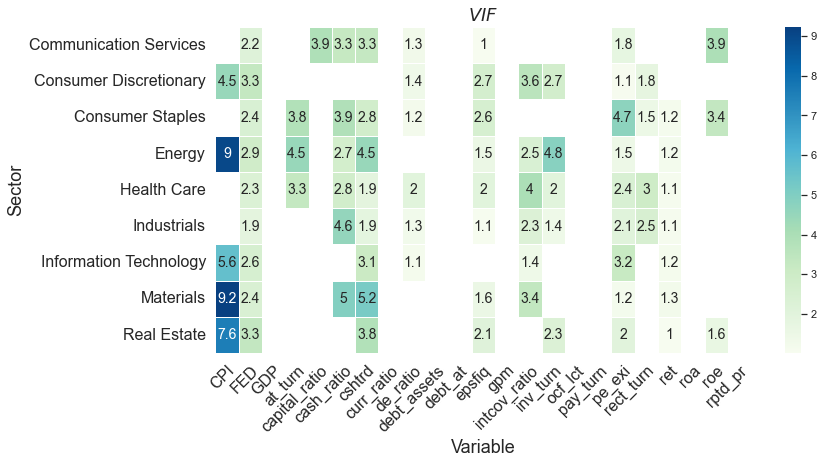

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(dfs.T, cmap="GnBu", linewidth = 1 , annot = True ,annot_kws={"size": 14})

ax.set_title('$VIF$', fontsize=18)
ax.set_xlabel('Variable', fontsize=18)
ax.set_ylabel('Sector', fontsize=18)

ax.xaxis.set_tick_params(labelsize=16, rotation=90)
ax.yaxis.set_tick_params(labelsize=16)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.savefig("D:/政大修課/111金融機構財務與風險管理/projectA/data/fig/vif.png" ,bbox_inches='tight')
plt.show()

In [168]:
for i in dfs.columns:
    print(dfs[i].dropna().index.values)

['FED' 'capital_ratio' 'cash_ratio' 'cshtrd' 'de_ratio' 'epsfiq' 'pe_exi'
 'roe']
['CPI' 'FED' 'de_ratio' 'epsfiq' 'intcov_ratio' 'inv_turn' 'pe_exi'
 'rect_turn']
['FED' 'at_turn' 'cash_ratio' 'cshtrd' 'de_ratio' 'epsfiq' 'pe_exi'
 'rect_turn' 'ret' 'roe']
['FED' 'at_turn' 'cash_ratio' 'cshtrd' 'de_ratio' 'epsfiq' 'intcov_ratio'
 'inv_turn' 'pe_exi' 'rect_turn' 'ret']
['FED' 'cash_ratio' 'cshtrd' 'de_ratio' 'epsfiq' 'intcov_ratio' 'inv_turn'
 'pe_exi' 'rect_turn' 'ret']


,FED,capital_ratio,cash_ratio,cshtrd,de_ratio,epsfiq,pe_exi,roe
0,1.97,1.288,0.534,1.200385e+07,-4.913,-1.12,-0.088,0.086456
1,1.97,1.288,0.534,1.200385e+07,-4.913,-1.12,-0.088,0.086456
2,4.09,1.339,0.018,9.043386e+06,-4.304,-1.06,-0.341,0.086456
3,1.97,1.288,0.534,1.200385e+07,-4.913,-1.12,-0.088,0.086456
4,4.09,1.339,0.018,9.043386e+06,-4.304,-1.06,-0.341,0.086456
...,...,...,...,...,...,...,...,...
1386,0.05,0.570,0.086,1.730750e+07,3.434,-0.23,22.403,0.064000
1388,0.05,0.570,0.086,1.730750e+07,3.434,-0.23,22.403,0.064000
1390,0.05,0.570,0.086,1.730750e+07,3.434,-0.23,22.403,0.064000
1392,0.05,0.570,0.086,1.730750e+07,3.434,-0.23,22.403,0.064000


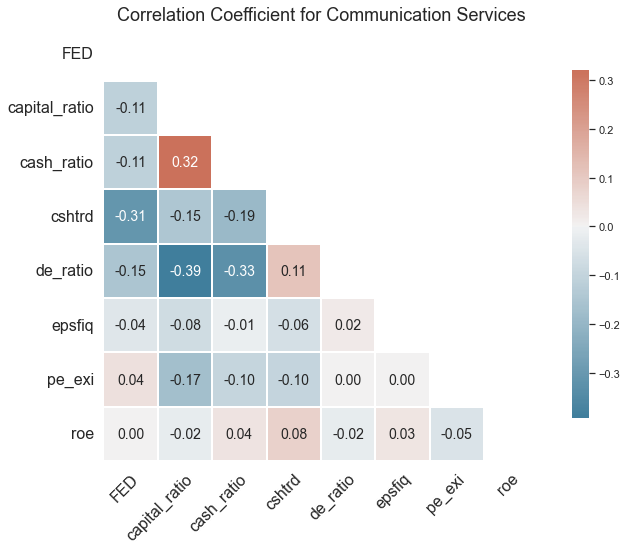

,CPI,FED,de_ratio,epsfiq,intcov_ratio,inv_turn,pe_exi,rect_turn
0,185.500,0.94,-3.351404,-0.614047,1.39568,16.037839,4.400521,4.315968
1,191.700,1.97,-3.351404,-0.614047,1.39568,16.037839,4.400521,4.315968
2,198.100,4.09,-3.351404,-0.614047,1.39568,16.037839,4.400521,4.315968
3,203.100,5.17,-3.351404,-0.614047,1.39568,16.037839,4.400521,4.315968
4,211.445,3.06,-3.351404,-0.614047,1.39568,16.037839,4.400521,4.315968
...,...,...,...,...,...,...,...,...
3363,211.445,3.06,5.358000,0.440000,6.40700,65.520000,24.214000,46.813000
3364,211.398,0.14,-61.435000,0.430000,5.57700,58.339000,17.015000,47.620000
3365,217.347,0.05,5.887000,0.450000,7.29200,55.517000,19.108000,33.647000
3367,217.347,0.05,5.887000,0.450000,7.29200,55.517000,19.108000,33.647000


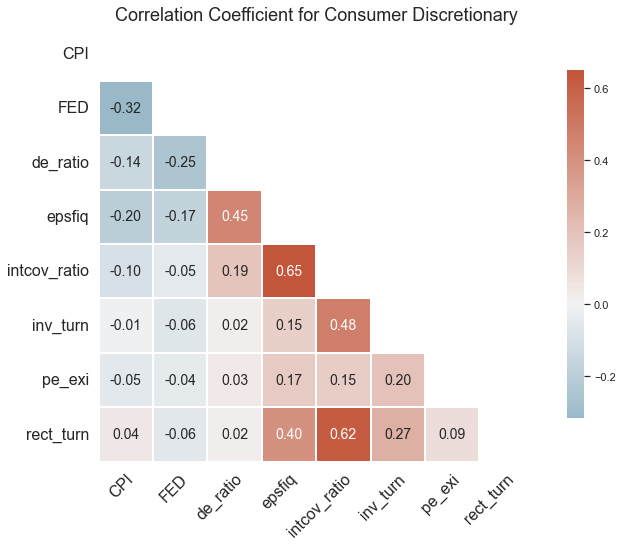

,FED,at_turn,cash_ratio,cshtrd,de_ratio,epsfiq,pe_exi,rect_turn,ret,roe
0,0.94,1.830000,0.223000,1.624822e+06,1.517000,0.15,19.511000,9.044000,0.002198,0.077000
1,1.97,1.881000,0.216000,2.591752e+06,1.460000,-0.16,16.657000,8.454000,0.004612,0.083000
2,4.09,1.849000,0.307000,2.548689e+06,1.246000,0.30,23.295000,8.620000,0.000050,0.109000
3,0.94,1.830000,0.223000,1.624822e+06,1.517000,0.15,19.511000,9.044000,0.002198,0.077000
4,1.97,1.881000,0.216000,2.591752e+06,1.460000,-0.16,16.657000,8.454000,0.004612,0.083000
...,...,...,...,...,...,...,...,...,...,...
1430,0.14,1.351419,0.248174,2.706318e+07,1.421303,1.02,16.623087,16.041866,-0.000479,0.323013
1431,0.05,1.351419,0.248174,1.475489e+07,1.421303,0.96,16.623087,16.041866,0.001415,0.323013
1433,0.05,1.351419,0.248174,1.475489e+07,1.421303,0.96,16.623087,16.041866,0.001415,0.323013
1435,0.05,1.351419,0.248174,1.475489e+07,1.421303,0.96,16.623087,16.041866,0.001415,0.323013


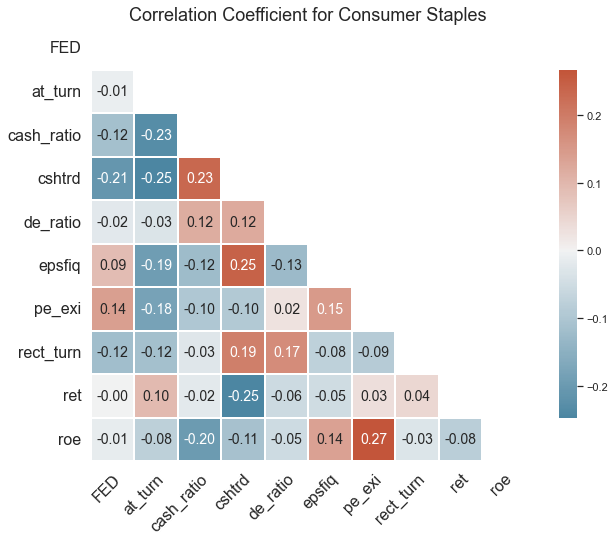

,CPI,FED,at_turn,cash_ratio,cshtrd,epsfiq,intcov_ratio,inv_turn,pe_exi,ret
0,191.700,1.97,0.380,0.087,2.311939e+06,1.52,16.570,7.674,11.169,0.000198
1,203.100,5.17,0.371,0.037,3.365873e+06,1.56,17.936,7.624,9.490,0.001260
2,185.500,0.94,0.384,0.041,1.239330e+06,1.60,11.998,7.934,12.499,0.002376
3,191.700,1.97,0.380,0.087,2.311939e+06,1.52,16.570,7.674,11.169,0.000198
4,198.100,4.09,0.429,0.105,3.655321e+06,2.35,23.417,8.980,9.061,-0.001202
...,...,...,...,...,...,...,...,...,...,...
814,185.500,0.94,1.304,0.277,1.154820e+07,1.01,33.261,19.567,13.508,0.001527
815,191.700,1.97,1.429,0.538,1.219452e+07,1.30,31.522,22.056,14.661,0.000798
816,198.100,4.09,1.626,0.719,1.978519e+07,1.71,52.690,26.966,11.047,-0.001614
817,203.100,5.17,1.568,0.673,1.986498e+07,1.76,48.090,25.084,11.991,0.002242


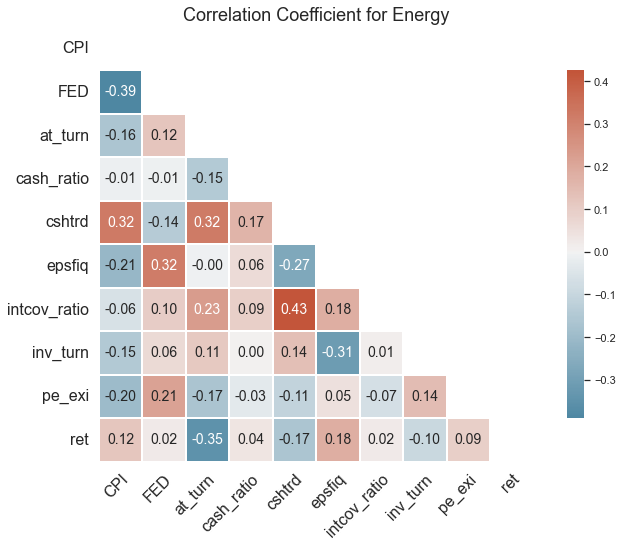

,FED,at_turn,cash_ratio,cshtrd,de_ratio,epsfiq,intcov_ratio,inv_turn,pe_exi,rect_turn,ret
0,1.97,1.146096,0.565783,2.596256e+06,1.904531,0.15000,18.045944,8.476062,20.440998,11.093111,0.000993
1,3.06,1.146096,0.565783,2.037672e+06,1.904531,0.46000,18.045944,8.476062,20.440998,11.093111,0.000065
2,0.14,1.146096,0.565783,4.074502e+06,1.904531,0.64000,18.045944,8.476062,20.440998,11.093111,-0.008882
3,0.05,1.146096,0.565783,2.780978e+06,1.904531,0.07000,18.045944,8.476062,20.440998,11.093111,0.002576
5,0.05,1.146096,0.565783,2.780978e+06,1.904531,0.07000,18.045944,8.476062,20.440998,11.093111,0.002576
...,...,...,...,...,...,...,...,...,...,...,...
1275,0.05,1.146096,0.565783,7.200614e+06,1.904531,0.73664,18.045944,8.476062,20.440998,11.093111,0.007648
1276,5.17,1.146096,0.565783,7.200614e+06,1.904531,0.73664,18.045944,8.476062,20.440998,11.093111,0.007648
1277,3.06,1.146096,0.565783,7.200614e+06,1.904531,0.73664,18.045944,8.476062,20.440998,11.093111,0.007648
1278,0.14,1.146096,0.565783,7.200614e+06,1.904531,0.73664,18.045944,8.476062,20.440998,11.093111,0.007648


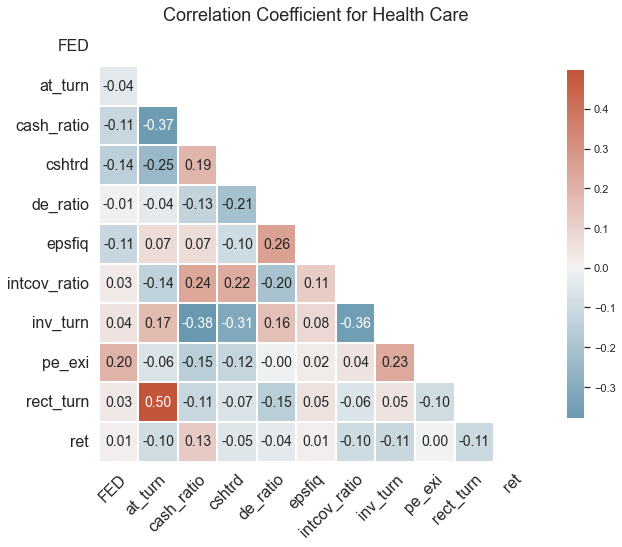

,FED,cash_ratio,cshtrd,de_ratio,epsfiq,intcov_ratio,inv_turn,pe_exi,rect_turn,ret
0,0.94,0.204262,2.551301e+07,4.475407,0.218747,4.623331,9.920725,19.714222,3.768926,0.000216
1,1.97,0.204262,2.551301e+07,4.475407,0.218747,4.623331,9.920725,19.714222,3.768926,0.000216
2,5.17,0.204262,2.551301e+07,4.475407,0.218747,4.623331,9.920725,19.714222,3.768926,0.000216
3,5.17,0.204262,2.551301e+07,4.475407,0.218747,4.623331,9.920725,19.714222,3.768926,0.000216
4,3.06,0.204262,2.551301e+07,4.475407,0.218747,4.623331,9.920725,19.714222,3.768926,0.000216
...,...,...,...,...,...,...,...,...,...,...
9544,0.14,0.158000,4.801255e+06,2.379000,0.440000,4.775000,78.254000,12.178000,7.646000,0.001885
9545,3.06,0.134000,3.045723e+06,2.430000,0.610000,4.183000,81.186000,16.188000,7.100000,-0.002326
9546,5.17,0.188000,2.112421e+06,2.267000,0.460000,3.684000,85.870000,17.814000,6.920000,0.000089
9547,3.06,0.134000,3.045723e+06,2.430000,0.610000,4.183000,81.186000,16.188000,7.100000,-0.002326


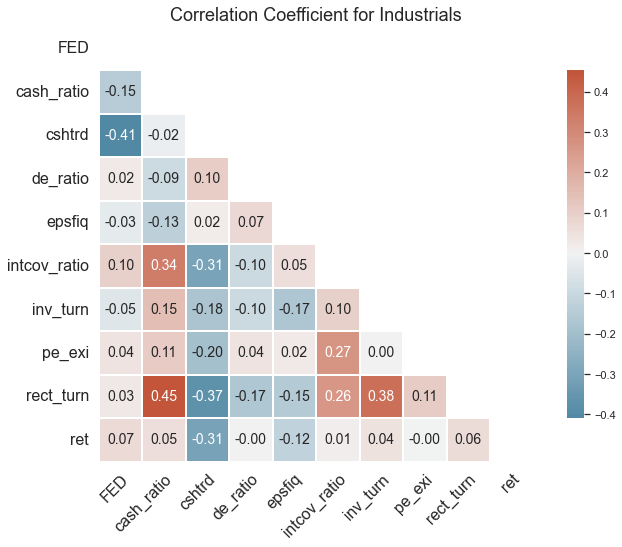

,CPI,FED,cshtrd,de_ratio,intcov_ratio,pe_exi,ret
2,217.347,0.05,3.886007e+06,1.780365,24.73706,16.967682,0.002876
4,198.100,4.09,1.382860e+07,1.780365,24.73706,16.967682,0.000320
5,203.100,5.17,1.382860e+07,1.780365,24.73706,16.967682,0.000320
6,211.398,0.14,1.382860e+07,1.780365,24.73706,16.967682,0.000320
7,217.347,0.05,1.382860e+07,1.780365,24.73706,16.967682,0.000320
...,...,...,...,...,...,...,...
518,191.700,1.97,1.382860e+07,1.780365,24.73706,16.967682,0.000320
519,198.100,4.09,1.382860e+07,1.780365,24.73706,16.967682,0.000320
520,185.500,0.94,1.382860e+07,1.780365,24.73706,16.967682,0.000320
521,211.398,0.14,1.382860e+07,1.780365,24.73706,16.967682,0.000320


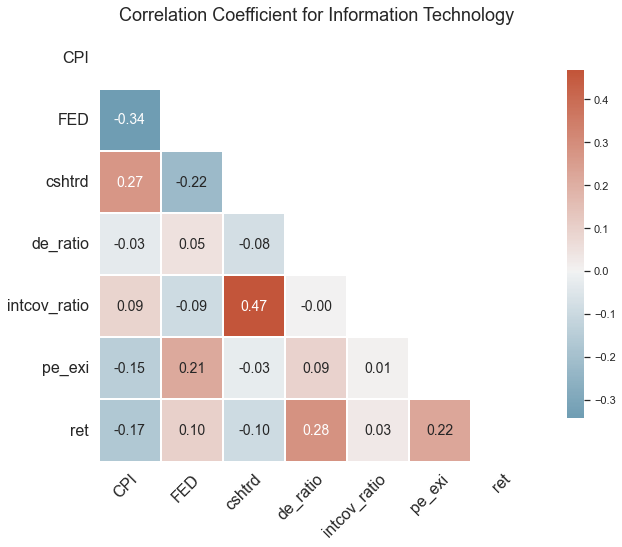

,CPI,FED,cash_ratio,cshtrd,epsfiq,intcov_ratio,pe_exi,ret
1,198.100,4.09,0.139,2.654825e+05,0.67,3.880,19.842,0.000270
2,203.100,5.17,0.310,3.632302e+05,1.29,5.904,28.878,0.004565
3,211.445,3.06,0.324,9.276075e+05,0.60,7.350,15.852,-0.000781
4,211.398,0.14,0.578,1.029583e+06,0.14,7.281,12.771,-0.002600
5,217.347,0.05,0.874,6.035293e+05,0.68,7.885,23.415,0.001937
...,...,...,...,...,...,...,...,...
1252,217.347,0.05,0.031,1.103090e+06,-0.11,0.669,311.200,0.000864
1254,211.398,0.14,0.028,1.798269e+06,-1.97,2.212,-241.670,0.001398
1255,217.347,0.05,0.031,1.103090e+06,-0.11,0.669,311.200,0.000864
1257,211.398,0.14,0.028,1.798269e+06,-1.97,2.212,-241.670,0.001398


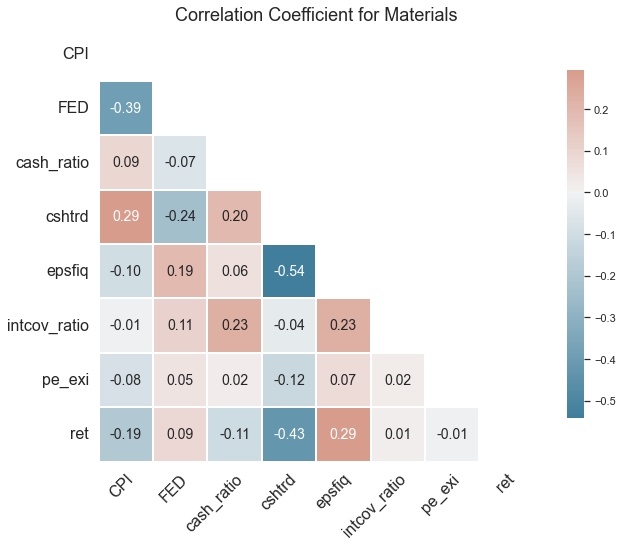

,CPI,FED,cshtrd,epsfiq,inv_turn,pe_exi,ret,roe
0,185.500,0.94,1.585130e+06,-0.33,52.981000,-9.803,0.001649,-0.158
1,198.100,4.09,3.139575e+06,-0.22,12.256745,-72.638,0.001523,-0.048
2,203.100,5.17,2.513778e+06,0.04,12.256745,344.000,0.000742,0.006
3,211.445,3.06,4.371066e+06,-0.01,12.256745,197.364,-0.000412,0.025
4,211.398,0.14,5.692393e+06,0.21,12.256745,54.759,-0.001554,0.079
...,...,...,...,...,...,...,...,...
793,185.500,0.94,9.136131e+05,0.41,4.313000,45.538,0.001237,0.026
794,191.700,1.97,9.948859e+05,0.82,4.489000,12.635,0.000227,0.102
795,198.100,4.09,1.166189e+06,-0.86,4.356000,29.860,-0.000375,0.042
796,203.100,5.17,1.621749e+06,2.12,3.861000,55.014,0.002226,0.027


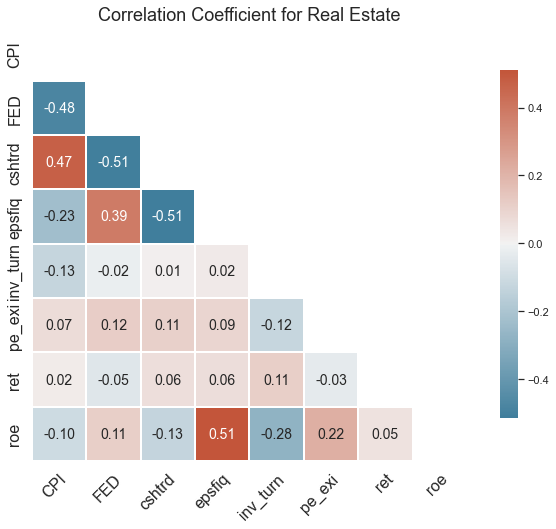

OKOK


In [237]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

dfs = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/vif/vif_final.csv")
dfs = dfs.set_index('feature')

for i in dfs.columns:

    df = pd.read_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final_{i}.csv")
    df = df.loc[(df['year']<2010)]
    df.fillna(df.mean(axis=0,numeric_only=True,skipna=True), inplace=True)
    
    x = df[dfs[i].dropna().index.values]
    
    display(x)

    y = df[['yld_pt']]

    sns.set_theme(style="white")

    corr = x.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(12, 8))

    ax.set_title(f'Correlation Coefficient for {i}', fontsize=18)
    ax.tick_params(labelsize=16)
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, 
                annot = True ,annot_kws={"size": 14}, fmt='.2f')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
   
    
    plt.savefig(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/fig/corr_{i}.png" ,bbox_inches='tight')
    plt.show()
print('OKOK')

# regression

In [238]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import joblib

df = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/vif/vif_final.csv")
df = df.set_index('feature')

for c in df.columns[:]:
    print(c)
    var_x = df[c].dropna().index.values#經過vif篩選，要用的特徵
    dfs = pd.read_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final_{c}.csv")
    dfs = dfs.loc[(dfs['year']<2010)]
    dfs.fillna(dfs.mean(axis=0,numeric_only=True,skipna=True), inplace=True)

    x = dfs[var_x]
    y = dfs[['yld_pt']]
    
    while True:
#         x = sm.add_constant(x)
        x.insert(loc=0, column='const', value=np.ones(len(x))) if 'const' not in x.columns else x
        model = sm.OLS(y, x).fit()
#         print(model.summary())
        if model.pvalues[1:].max()>0.05:
            delx = model.pvalues[1:].idxmax()
            x = x.drop(delx, axis=1)
        else:
            print('break')
            #save model
            filename = f"D:/政大修課/111金融機構財務與風險管理/projectA/data/model/model_{c}.sav"
            joblib.dump(model, filename)
                       
            #R2 table
            rtable = model.summary2().tables[0]
            rtable.to_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/table/R_{c}.csv", index=False)

            #pvalue table
            ptable = model.summary2().tables[1]
            ptable.to_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/table/pvalue_{c}.csv", index=False)
            
            display(model.summary())
            break
            
            model

        
print('OKOK')


Communication Services
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     95.13
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.08e-70
Time:                        01:53:36   Log-Likelihood:                -6230.9
No. Observations:                1215   AIC:                         1.247e+04
Df Residuals:                    1210   BIC:                         1.250e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.4488      3.774      9.129      0.000      27.045      41.852
capital_ratio    21.7084      4.374      4.963      0.000      13.126      30.291
cash_ratio       23.4920      9.708      2.420      0.016       4.447      42.537
pe_exi           -0.1387      0.061     -2.261      0.024      -0.259      -0.018
roe            -446.9134     24.667    -18.118      0.000    -495.308    -398.519
==============================================================================
Omnibus:                     2672.393   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14186280.179
Skew:                          18.737   Prob(JB):                         0.00
Kurtosis:                     531.033   Cond. No.                         571.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Consumer Discretionary
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     38.34
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.55e-38
Time:                        01:53:36   Log-Likelihood:                -14860.
No. Observations:                3153   AIC:                         2.973e+04
Df Residuals:                    3147   BIC:                         2.977e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -39.5877     12.332     -3.210      0.001     -63.767     -15.409
CPI            0.2836      0.059      4.788      0.000       0.167       0.400
FED           -1.9798      0.296     -6.695      0.000      -2.560      -1.400
de_ratio       0.0330      0.015      2.137      0.033       0.003       0.063
epsfiq        -2.6777      0.332     -8.063      0.000      -3.329      -2.027
inv_turn      -0.0636      0.029     -2.203      0.028      -0.120      -0.007
==============================================================================
Omnibus:                     7060.207   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         48580792.533
Skew:                          20.505   Prob(JB):                         0.00
Kurtosis:                     609.717   Cond. No.                     5.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Consumer Staples
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     12.13
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           7.98e-08
Time:                        01:53:36   Log-Likelihood:                -3636.6
No. Observations:                1245   AIC:                             7281.
Df Residuals:                    1241   BIC:                             7302.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7426      0.315     18.208      0.000       5.124       6.361
FED            0.3141      0.070      4.493      0.000       0.177       0.451
epsfiq        -0.6265      0.233     -2.692      0.007      -1.083      -0.170
pe_exi        -0.0515      0.015     -3.408      0.001      -0.081      -0.022
==============================================================================
Omnibus:                     2319.953   Durbin-Watson:                   1.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2323165.097
Skew:                          13.463   Prob(JB):                         0.00
Kurtosis:                     212.902   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Energy
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                nan
Time:                        01:53:37   Log-Likelihood:                -3255.8
No. Observations:                 707   AIC:                             6514.
Df Residuals:                     706   BIC:                             6518.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7108      0.911      8.468      0.000       5.923       9.499
==============================================================================
Omnibus:                     1630.195   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6255183.557
Skew:                          20.050   Prob(JB):                         0.00
Kurtosis:                     462.056   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Health Care
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     22.58
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.28e-06
Time:                        01:53:37   Log-Likelihood:                -12658.
No. Observations:                1079   AIC:                         2.532e+04
Df Residuals:                    1077   BIC:                         2.533e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -194.6347    947.583     -0.205      0.837   -2053.953    1664.683
ret          1.48e+05   3.11e+04      4.752      0.000    8.69e+04    2.09e+05
==============================================================================
Omnibus:                     2955.023   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47896385.625
Skew:                          31.781   Prob(JB):                         0.00
Kurtosis:                    1033.199   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Industrials
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                nan
Time:                        01:53:37   Log-Likelihood:                -89073.
No. Observations:                8308   AIC:                         1.781e+05
Df Residuals:                    8307   BIC:                         1.782e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.0720    120.306      1.056      0.291    -108.758     362.902
==============================================================================
Omnibus:                    32108.326   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      23874634634.078
Skew:                          91.130   Prob(JB):                         0.00
Kurtosis:                    8305.734   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Information Technology
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     16.20
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           6.74e-05
Time:                        01:53:37   Log-Likelihood:                -1757.0
No. Observations:                 436   AIC:                             3518.
Df Residuals:                     434   BIC:                             3526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5429      0.669     11.272      0.000       6.228       8.858
de_ratio      -0.3278      0.081     -4.024      0.000      -0.488      -0.168
==============================================================================
Omnibus:                      805.680   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           487208.663
Skew:                          11.786   Prob(JB):                         0.00
Kurtosis:                     165.059   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Materials
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     9.337
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           3.03e-11
Time:                        01:53:37   Log-Likelihood:                -2710.3
No. Observations:                1017   AIC:                             5437.
Df Residuals:                    1009   BIC:                             5476.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8272      2.522     -1.121      0.263      -7.776       2.121
CPI              0.0427      0.012      3.492      0.001       0.019       0.067
FED              0.2343      0.064      3.635      0.000       0.108       0.361
cash_ratio      -1.8138      0.507     -3.577      0.000      -2.809      -0.819
cshtrd       -1.459e-07   5.69e-08     -2.563      0.011   -2.58e-07   -3.42e-08
epsfiq          -0.2150      0.062     -3.460      0.001      -0.337      -0.093
intcov_ratio     0.0459      0.022      2.068      0.039       0.002       0.089
ret           -179.4746     47.323     -3.793      0.000    -272.337     -86.612
==============================================================================
Omnibus:                     2128.460   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6599414.330
Skew:                          16.617   Prob(JB):                         0.00
Kurtosis:                     396.235   Cond. No.                     1.90e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Real Estate
break


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yld_pt   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           3.51e-09
Time:                        01:53:38   Log-Likelihood:                -2491.2
No. Observations:                 691   AIC:                             4988.
Df Residuals:                     688   BIC:                             5002.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7615      0.560     10.291      0.000       4.662       6.861
cshtrd      1.872e-06   3.11e-07      6.029      0.000    1.26e-06    2.48e-06
pe_exi        -0.0170      0.007     -2.561      0.011      -0.030      -0.004
==============================================================================
Omnibus:                     1317.452   Durbin-Watson:                   1.367
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1362017.818
Skew:                          13.323   Prob(JB):                         0.00
Kurtosis:                     218.861   Cond. No.                     2.64e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

OKOK


In [239]:
dfs

,bond_sym_id,year,month_x,trd_exctn_datetime,Symbol,bsym,trd_exctn_dt,trd_exctn_tm,ascii_rptd_vol_tx,rptd_pr,...,inv_turn,at_turn,rect_turn,pay_turn,epsfiq,CPI,GDP,FED,ret,cshtrd
0,AMT.GF,2003,12,2003-12-16 14:48:01,AMT,NaN,2003-12-16,14:48:01,25000,93.250,...,52.981000,0.131,7.734,2.933,-0.33,185.500,11772.234,0.94,0.001649,1.585130e+06
1,AMT.GF,2005,12,2005-12-22 12:13:20,AMT,NaN,2005-12-22,12:13:20,1MM+,98.875,...,12.256745,0.136,24.985,1.724,-0.22,198.100,13324.204,4.09,0.001523,3.139575e+06
2,AMT.GF,2006,12,2006-12-12 16:03:00,AMT,NaN,2006-12-12,16:03:00,100000,100.900,...,12.256745,0.151,39.702,1.937,0.04,203.100,14039.560,5.17,0.000742,2.513778e+06
3,AMT.GF,2007,12,2007-12-19 11:29:39,AMT,NaN,2007-12-19,11:29:39,10000,99.250,...,12.256745,0.174,41.806,1.981,-0.01,211.445,14715.058,3.06,-0.000412,4.371066e+06
4,AMT.GF,2008,12,2008-12-31 12:37:32,AMT,NaN,2008-12-31,12:37:32,100000,95.125,...,12.256745,0.195,34.782,2.381,0.21,211.398,14608.208,0.14,-0.001554,5.692393e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,WY.HL,2003,12,2003-12-31 14:34:00,WY,NaN,2003-12-31,14:34:00,100000,103.393,...,4.313000,0.706,13.109,15.204,0.41,185.500,11772.234,0.94,0.001237,9.136131e+05
794,WY.HL,2004,12,2004-12-16 12:22:00,WY,NaN,2004-12-16,12:22:00,67000,100.571,...,4.489000,0.781,14.188,15.492,0.82,191.700,12527.214,1.97,0.000227,9.948859e+05
795,WY.HP,2005,12,2005-12-29 08:39:07,WY,NaN,2005-12-29,8:39:07,47000,101.398,...,4.356000,0.778,13.249,14.635,-0.86,198.100,13324.204,4.09,-0.000375,1.166189e+06
796,WY.HP,2006,12,2006-12-27 11:06:28,WY,NaN,2006-12-27,11:06:28,46000,100.039,...,3.861000,0.795,12.577,15.509,2.12,203.100,14039.560,5.17,0.002226,1.621749e+06


# Estimate and True

In [3]:
#填補平均值
def fill_mean(df):
    df.fillna(df.mean(axis=0,numeric_only=True,skipna=True), inplace=True)
    return df

#估計
def estimate_true(df, direction, period):

    if len(var_x) != 1:
        x = df[var_x[1:]]
        x.insert(loc=0, column='const', value=np.ones(len(x))) if 'const' not in x.columns else x
    else:
        x = np.ones(len(df))
        
    y = (df[['yld_pt']].values).reshape(len(df))
    estimate = model.predict(x)

    result = pd.DataFrame([y, estimate], index=['true','estimate']).T
    result.to_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/ADYP/{c}_{direction}_{period}.csv', index=False)

    return result

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import joblib

df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
sector = np.unique(df_wiki['GICS Sector'])

# c = 'Industrials'
for c in sector:
    print(c)
    dfs = pd.read_csv(f"D:/政大修課/111金融機構財務與風險管理/projectA/data/variable/final_{c}.csv")

    #分類
    u_b = fill_mean(dfs[(dfs['dir_diff']=='up')&(dfs['year']<2010)]) # up and before
    d_b = fill_mean(dfs[(dfs['dir_diff']=='down')&(dfs['year']<2010)]) # down and before
    f_b = fill_mean(dfs[(dfs['dir_diff']=='flat')&(dfs['year']<2010)]) # flat and before
    
    ud_b = fill_mean(dfs[(dfs['dir_diff']=='up')|(dfs['dir_diff']=='down')&(dfs['year']<2010)]) # up & down and before
    udf_b = fill_mean(dfs[(dfs['year']<2010)]) # up & down & flat and before
    
    u_a = fill_mean(dfs[(dfs['dir_diff']=='up')&(dfs['year']==2010)]) # up and after
    d_a = fill_mean(dfs[(dfs['dir_diff']=='down')&(dfs['year']==2010)]) # down and after
    f_a = fill_mean(dfs[(dfs['dir_diff']=='flat')&(dfs['year']==2010)]) # flat and after
    
    ud_a = fill_mean(dfs[(dfs['dir_diff']=='up')|(dfs['dir_diff']=='down')&(dfs['year']==2010)]) # up & down and after
    udf_a = fill_mean(dfs[(dfs['year']==2010)]) # up & down & flat and after

    #load model
    filename = f"D:/政大修課/111金融機構財務與風險管理/projectA/data/model/model_{c}.sav"
    model = joblib.load(filename)
    print(model.summary())

    var_x = model.summary2().tables[1].index#要用的特徵
    
    print(var_x)

    estimate_true(u_b, 'up', 'before')
    estimate_true(d_b, 'down', 'before')
    estimate_true(f_b, 'flat', 'before')
    estimate_true(u_a, 'up', 'after')
    estimate_true(d_a, 'down', 'after')
    estimate_true(f_a, 'flat', 'after')
    
    estimate_true(ud_b, 'updown', 'before')
    estimate_true(udf_b, 'updownflat', 'before')
    
    estimate_true(ud_a, 'updown', 'after')
    estimate_true(udf_a, 'updownflat', 'after')

print('OKOK')

Communication Services


C:\Users\USER\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


                            OLS Regression Results                            
Dep. Variable:                 yld_pt   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     95.13
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.08e-70
Time:                        16:19:38   Log-Likelihood:                -6230.9
No. Observations:                1215   AIC:                         1.247e+04
Df Residuals:                    1210   BIC:                         1.250e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.4488      3.774      9.129

                            OLS Regression Results                            
Dep. Variable:                 yld_pt   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     22.58
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           2.28e-06
Time:                        16:19:43   Log-Likelihood:                -12658.
No. Observations:                1079   AIC:                         2.532e+04
Df Residuals:                    1077   BIC:                         2.533e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -194.6347    947.583     -0.205      0.8

                            OLS Regression Results                            
Dep. Variable:                 yld_pt   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     20.03
Date:                Sat, 29 Apr 2023   Prob (F-statistic):           3.51e-09
Time:                        16:19:48   Log-Likelihood:                -2491.2
No. Observations:                 691   AIC:                             4988.
Df Residuals:                     688   BIC:                             5002.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7615      0.560     10.291      0.0

# $Y_{diff}$ and AY

$S^{2}_p=\frac{(n_1-1)S^2_1+(n_2-1)S^2_2}{n_1+n_2-2}=(\frac{n_1-1}{n_1+n_2-2})S^2_1+(\frac{n_2-1}{n_1+n_2-2})S^2_2$ 

$t=\frac{AY_{after}-AY_{before}}{\sqrt{S^{2}_p(\frac{1}{n_1}+\frac{1}{n_2})}}=\frac{AY_{after}-AY_{before}}{S_p\sqrt{(\frac{1}{n_1}+\frac{1}{n_2})}}$

In [20]:
import scipy.stats
dir_ls = ['up', 'down', 'flat', 'updown', 'updownflat']
df1_ls = []
df2_ls = []

data = pd.DataFrame()

for s in sector[:]:
    for d in dir_ls[:]:
        print(s, d)
        #read before and after of Y
        df1 = pd.read_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/ADYP/{s}_{d}_before.csv')
        df2 = pd.read_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/ADYP/{s}_{d}_after.csv')
        
        #Y diff
        df1_diff = abs(df1['true'] - df1['estimate'])
        df2_diff = abs(df2['true'] - df2['estimate'])
        
        # AY diff mean
        df1_mean = df1_diff.mean()
        df2_mean = df2_diff.mean()
        
        # AY diff std
        df1_std = df1_diff.std()
        df2_std = df2_diff.std()
        
        #sample size
        df1_n = len(df1)
        df2_n = len(df2)
        
        print('df1', df1_mean, df1_std, df1_n)
        print('df2', df2_mean, df2_std, df2_n)
    
#         # AY diff mean
#         df1_mean = 0.209
#         df2_mean = 0.275
        
#         # AY diff std
#         df1_std = 1.240
#         df2_std = 1.232
        
#         #sample size
#         df1_n = 3198
#         df2_n = 2214
       
        if df1_n == 0 or df2_n == 0:
            continue
        else:
            #S^2_p and t by Pooled Two-sampled t-test
            SSP = ((df1_n-1)*df1_std**2+(df2_n-1)*df2_std**2)/(df1_n+df2_n-2)
            t = (df1_mean-df2_mean)/((SSP*(df1_n**(-1)+df2_n**(-1)))**0.5)

            #find p-value for two-tailed test
            pvalue = scipy.stats.t.sf(abs(t), df=(df1_n+df2_n-2))*2
            print('S', SSP, t, pvalue)

            df1_ls.append([df1_mean, df1_std, df1_n, t, pvalue, s, d, 'before'])
            df2_ls.append([df2_mean, df2_std, df2_n, t, pvalue, s, d, 'after'])
        
data1 = pd.DataFrame(df1_ls, columns=['mean', 'std', 'n', 't', 'pvalue', 'sector', 'direction', 'period'])
data2 = pd.DataFrame(df2_ls, columns=['mean', 'std', 'n', 't', 'pvalue', 'sector', 'direction', 'period'])

data = data1.append(data2)
data.sort_values(['direction', 'sector'], inplace=True)

data = data[['sector', 'direction', 'period', 'mean', 'std', 'n', 't', 'pvalue']]

data.to_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/ADYP/total.csv', index=False)
display(data)
print('OKOK')

Communication Services up
df1 63.61968980838972 65.04789442030483 27
df2 72.38519599450002 100.23011297234989 6
S 5169.107113343333 -0.27012810509515645 0.7888519354342174
Communication Services down
df1 8.886221265261682 9.145663285868146 760
df2 25.55591638114139 4.300605542781152 121
S 74.74923899938075 -19.69861971128493 7.817963656308338e-72
Communication Services flat
df1 30.71034294287252 74.23061623380393 265
df2 58.40591307056505 69.12420686699443 22
S 5456.245450869069 -1.6898832033252171 0.09214378050369021
Communication Services updown
df1 11.23022819973821 20.23998944418466 793
df2 34.05395248643917 36.48056585476843 154
S 558.7997128008743 -10.964286867419107 2.0493646042276658e-26
Communication Services updownflat
df1 13.314717220693684 38.6123776530394 1215
df2 26.01861136988691 32.89969751437397 181
S 1438.1649117031075 -4.204527907262936 2.7829389038840172e-05
Consumer Discretionary up
df1 8.522914607898473 22.323822958788146 2336
df2 9.097290837970087 3.1577135874794

,sector,direction,period,mean,std,n,t,pvalue
1,Communication Services,down,before,8.886221,9.145663,760,-19.698620,7.817964e-72
1,Communication Services,down,after,25.555916,4.300606,121,-19.698620,7.817964e-72
6,Consumer Discretionary,down,before,13.360420,29.681660,170,-0.575584,5.655737e-01
6,Consumer Discretionary,down,after,16.931730,1.880219,23,-0.575584,5.655737e-01
11,Consumer Staples,down,before,1.117769,2.057909,56,-0.994063,3.237162e-01
...,...,...,...,...,...,...,...,...
32,Information Technology,updownflat,after,4.283656,4.403331,88,-0.385538,6.999957e-01
37,Materials,updownflat,before,1.380374,3.192503,1017,-2.045190,4.104384e-02
37,Materials,updownflat,after,1.813605,1.720598,243,-2.045190,4.104384e-02
39,Real Estate,updownflat,before,2.663260,8.500228,691,-2.468138,1.379070e-02


OKOK


# read regression summary table

In [76]:
df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
sector = np.unique(df_wiki['GICS Sector'])

for c in sector[:]:
    print(c)
    #load model
    filename = f"D:/政大修課/111金融機構財務與風險管理/projectA/data/model/model_{c}.sav"
    model = joblib.load(filename)

    table = model.summary2().tables[1]
    var = pd.DataFrame(table.index, columns=['var'])
    coef = pd.DataFrame(np.round(table['Coef.'].values,20), columns=['num'])
    dfs = pd.concat([coef.astype(str), var], axis=1)
    dfs['Y'] = dfs['num'] + dfs['var']
    
    
    R = model.summary2().tables[0]
    RR = float(R[1].values[-1]) #R square
    adjRR = float(R[3].values[0]) #adj R square
    n = float(R[1].values[3]) #sample size
    
    dfs['R'] = RR
    dfs['adjRR'] = adjRR 
    dfs['n'] = n
    
#     dfs.to_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/table/Y_{c}.csv', index=False)
    display(dfs)
print('OKOK')

Communication Services


,num,var,Y,R,adjRR,n
0,34.448792630903064,const,34.448792630903064const,0.239,0.237,1215.0
1,21.708424380823228,capital_ratio,21.708424380823228capital_ratio,0.239,0.237,1215.0
2,23.49202305434635,cash_ratio,23.49202305434635cash_ratio,0.239,0.237,1215.0
3,-0.13872882979923082,pe_exi,-0.13872882979923082pe_exi,0.239,0.237,1215.0
4,-446.9133574722618,roe,-446.9133574722618roe,0.239,0.237,1215.0


Consumer Discretionary


,num,var,Y,R,adjRR,n
0,-39.58769047170436,const,-39.58769047170436const,0.057,0.056,3153.0
1,0.28360306136775676,CPI,0.28360306136775676CPI,0.057,0.056,3153.0
2,-1.9798444430674023,FED,-1.9798444430674023FED,0.057,0.056,3153.0
3,0.033005375622020466,de_ratio,0.033005375622020466de_ratio,0.057,0.056,3153.0
4,-2.6777221262475672,epsfiq,-2.6777221262475672epsfiq,0.057,0.056,3153.0
5,-0.06362673902413962,inv_turn,-0.06362673902413962inv_turn,0.057,0.056,3153.0


Consumer Staples


,num,var,Y,R,adjRR,n
0,5.742590322393324,const,5.742590322393324const,0.028,0.026,1245.0
1,0.31409389646018643,FED,0.31409389646018643FED,0.028,0.026,1245.0
2,-0.6264537638167575,epsfiq,-0.6264537638167575epsfiq,0.028,0.026,1245.0
3,-0.05153729763842625,pe_exi,-0.05153729763842625pe_exi,0.028,0.026,1245.0


Energy


,num,var,Y,R,adjRR,n
0,7.710813516265909,const,7.710813516265909const,-0.0,-0.0,707.0


Health Care


,num,var,Y,R,adjRR,n
0,-194.6346971176824,const,-194.6346971176824const,0.021,0.02,1079.0
1,147952.75267742004,ret,147952.75267742004ret,0.021,0.02,1079.0


Industrials


,num,var,Y,R,adjRR,n
0,127.07198880609049,const,127.07198880609049const,-0.0,-0.0,8308.0


Information Technology


,num,var,Y,R,adjRR,n
0,7.542931245232493,const,7.542931245232493const,0.036,0.034,436.0
1,-0.3277718957141138,de_ratio,-0.3277718957141138de_ratio,0.036,0.034,436.0


Materials


,num,var,Y,R,adjRR,n
0,-2.827155941116953,const,-2.827155941116953const,0.061,0.054,1017.0
1,0.04266776505384629,CPI,0.04266776505384629CPI,0.061,0.054,1017.0
2,0.2343038446818962,FED,0.2343038446818962FED,0.061,0.054,1017.0
3,-1.8138077423015648,cash_ratio,-1.8138077423015648cash_ratio,0.061,0.054,1017.0
4,-1.4585910754055e-07,cshtrd,-1.4585910754055e-07cshtrd,0.061,0.054,1017.0
5,-0.2150070825685342,epsfiq,-0.2150070825685342epsfiq,0.061,0.054,1017.0
6,0.045919421331846316,intcov_ratio,0.045919421331846316intcov_ratio,0.061,0.054,1017.0
7,-179.47457808653832,ret,-179.47457808653832ret,0.061,0.054,1017.0


Real Estate


,num,var,Y,R,adjRR,n
0,5.76151001908106,const,5.76151001908106const,0.055,0.052,691.0
1,1.87214191295561e-06,cshtrd,1.87214191295561e-06cshtrd,0.055,0.052,691.0
2,-0.017035118185802854,pe_exi,-0.017035118185802854pe_exi,0.055,0.052,691.0


OKOK


In [29]:
import pandas as pd
import numpy as np

df_wiki = pd.read_csv("D:/政大修課/111金融機構財務與風險管理/projectA/data/wiki.csv")
sector = np.unique(df_wiki['GICS Sector'])

data = pd.DataFrame()

for c in sector[:]:
    print(c)
    df = pd.read_csv(f'D:/政大修課/111金融機構財務與風險管理/projectA/data/table/Y_{c}.csv')
    df['sector'] = c
    
    data = data.append(df)
    
d = data.drop_duplicates(['sector', 'R', 'adjRR', 'n'])[['sector', 'R', 'adjRR', 'n']]
d = d.T
d.columns = d.iloc[0]
d = d.drop(d.index[0])
display(d)

dfs = data.pivot(index='var', columns='sector', values='num')
dfs = dfs.append(d)
display(dfs)    
    
dfs.to_csv('D:/政大修課/111金融機構財務與風險管理/projectA/data/table/Y_total.csv')
print('OKKO')

Communication Services
Consumer Discretionary
Consumer Staples
Energy
Health Care
Industrials
Information Technology
Materials
Real Estate


sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Health Care,Industrials,Information Technology,Materials,Real Estate
R,0.239,0.057,0.028,-0.0,0.021,-0.0,0.036,0.061,0.055
adjRR,0.237,0.056,0.026,-0.0,0.02,-0.0,0.034,0.054,0.052
n,1215.0,3153.0,1245.0,707.0,1079.0,8308.0,436.0,1017.0,691.0


sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Health Care,Industrials,Information Technology,Materials,Real Estate
CPI,NaN,0.28,NaN,NaN,NaN,NaN,NaN,0.04,NaN
FED,NaN,-1.98,0.31,NaN,NaN,NaN,NaN,0.23,NaN
capital_ratio,21.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cash_ratio,23.49,NaN,NaN,NaN,NaN,NaN,NaN,-1.81,NaN
const,34.45,-39.59,5.74,7.71,-194.63,127.07,7.54,-2.83,5.76
cshtrd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0,0.0
de_ratio,NaN,0.03,NaN,NaN,NaN,NaN,-0.33,NaN,NaN
epsfiq,NaN,-2.68,-0.63,NaN,NaN,NaN,NaN,-0.22,NaN
intcov_ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,NaN
inv_turn,NaN,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


OKKO
